In [2]:
import numpy as np
from scipy.integrate import odeint
import scipy.stats
import matplotlib.pyplot as plt
import copy

In [3]:
# Import functions directly from github
# Important: note that we use raw.githubusercontent.com, not github.com

import requests
url = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/plot_utility.py'
r = requests.get(url)

# Store the file to the colab working directory
with open('plot_utility.py', 'w') as f:
    f.write(r.text)

# import the function we want from that file
from plot_utility import plot_tme

# Nominal trajectory, measurements

In [4]:
class MonoCamera:
    def __init__(self):
        self.std = 0.1
        self.v = scipy.stats.norm(0, self.std)
        
    def control(self, X, t):
        #g_des = (np.sin(0.05*t)+1)**4*np.sin(0.5*t)
        #g_des = np.sin(2*t)
        #g, d = X 
        #gain = 0.5
        # u_g = 4*np.sin(2*t) #gain*(g_des-g)
        u_g = np.piecewise(t,
                   [t < 2, (t >= 2) & (t < 8), t >= 8],
                   [0,
                    lambda t: 8*np.sin(10*t),
                    0])
        return u_g
    
    def f(self, X, t):
        g, d = X
        # control
        u_g = self.control(X, t)
        # dynamics
        g_dot = u_g # - 0.01*g
        d_dot = 0
        x_dot = [g_dot, d_dot]
        return x_dot
    
    # g = ground speed
    # d = distance
    def h(self, X, t):
        g, d = X
        u_g = self.control(X, t)
        # define all the sensors I want in the system to use for simulation
        # g = ground speed
        # d = distance
        y = np.array([g/d + self.v.rvs(g.shape), 
                      g + self.v.rvs(g.shape), 
                      d + self.v.rvs(d.shape),
                      5*g + self.v.rvs(g.shape)])
        return y
    
    def simulate(self, x0, tsim):
        result = odeint(self.f, x0, tsim)
        X = result.T
        U = np.atleast_2d(self.control(X, tsim))
        Y = self.h(X, tsim)
        return X, U, Y

In [5]:
sys = MonoCamera()

x0 = np.array([5, 3]) # initial conditions
tsim = np.arange(0, 10, 0.01) # simulation  time

X, U, Y = sys.simulate(x0, tsim)

(0.0, 10.0)

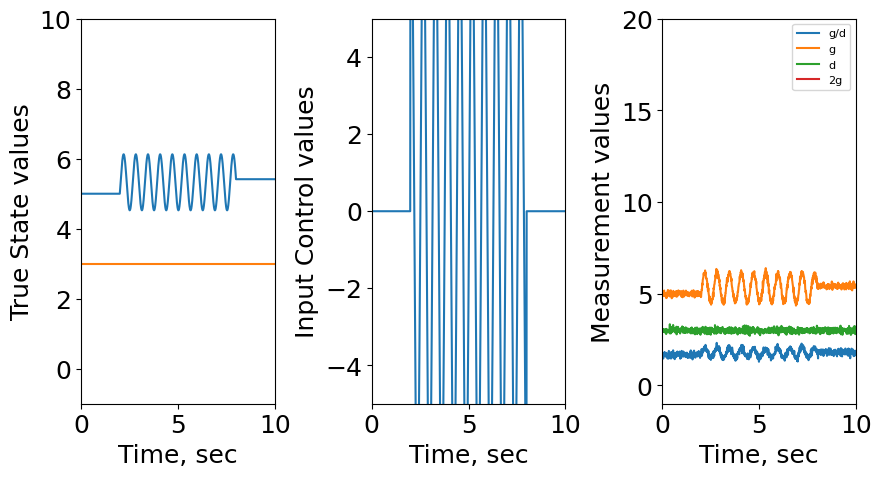

In [6]:
fig = plt.figure(figsize=(10,5))
fig.subplots_adjust(wspace=0.5)

# States
ax = fig.add_subplot(131)

ax.plot(tsim, X[0,:])
ax.plot(tsim, X[1,:])

ax.set_xlabel('Time, sec')
ax.set_ylabel('True State values')

ax.set_ylim([-1, 10])
ax.set_xlim([0, 10])

# Controls
ax = fig.add_subplot(132)

ax.plot(tsim, U[0,:])

ax.set_xlabel('Time, sec')
ax.set_ylabel('Input Control values')

ax.set_ylim([-5, 5])
ax.set_xlim([0, 10])

# Measurements
ax = fig.add_subplot(133)

ax.plot(tsim, Y[0,:], label='g/d')
ax.plot(tsim, Y[1,:], label='g')
ax.plot(tsim, Y[2,:], label='d')
ax.plot(tsim, Y[3,:], label='2g')
#ax.plot(tsim, Y[1,:])

# legend on the right
ax.legend(loc='upper right', fontsize=8)

ax.set_xlabel('Time, sec')
ax.set_ylabel('Measurement values')
ax.set_ylim([-1, 20])
ax.set_xlim([0, 10])

# Extended Kalman Filter

Note: this EKF function expects everything to be given as 2D arrays. 

## Initial conditions
Set up the initial conditions for the EKF. 

In [7]:
# Initial conditions
x0 = np.array([[5], [2.5]])
P0 = 1000000*np.eye(2)

# Noise defined by measurement noise
R = sys.std**2*np.eye(len(Y))
print(R.shape)

# Fairly accurate model
Q = 5e-4*np.eye(2)

(4, 4)


In [8]:
#!pip install git+https://github.com/florisvb/pyEKF.git

In [9]:
import ekf

In [10]:
def f_d(X, U):
    dt=0.01
    g, d = np.ravel(X)
    u, = np.ravel(U)
    g_dot = u # 0.01*g
    d_dot = 0
    x_new = np.atleast_2d(np.array([g + g_dot*dt, d + d_dot*dt])).T
    return x_new

def h_d(X, U):
    dt=0.01
    g, d = np.ravel(X)
    u, = np.ravel(U)
    # define the sensors that I will be giving the EKF
    sensors = [np.array( [g/d] ), np.array(g), np.array(d), np.array(2*g)]
    y = np.atleast_2d(np.hstack(sensors)).T
    return y

Use a modified R matrix to determine which combinations of sensors will be used by the EKF. Really large element of R means that the EKF will essentially ignore that sensor. According to Austin at least...

In [17]:
import itertools

def get_all_R(R_original):
    numbers = []
    for i in range(len(R)):
        numbers.append(i)

    all_combinations = []

    # Generate combinations
    for r in range(1, len(numbers) + 1):
        combs = list(itertools.combinations(numbers, r))
        all_combinations.extend(combs)

    R_modified = []

    for r in range(1, 5):
        for combo in itertools.combinations(range(4), r):
            matrix = R_original.copy()
            
            # Set large number for diagonals NOT in the combo
            for i in range(4):
                if i not in combo:
                    matrix[i, i] = 1e20
            
            R_modified.append(matrix)
    return R_modified

R_modified = get_all_R(R)

In [19]:
import pandas as pd

results = [pd.DataFrame(columns = ['x0_hat', 'x1_hat', 'P0', 'P1', 's0', 's1', 'invJk_x0', 'invJk_x1']) for _ in range(len(R_modified))]

for i in range(len(R_modified)):
    R = R_modified[i]
    # run the EKF

    xhat, P, s = ekf.ekf(Y, x0, f_d, h_d, Q, R, U)
    results[i]['x0_hat'] = xhat[0, :]
    results[i]['x1_hat'] = xhat[1, :]
    results[i]['P0'] = P[0, 0, :]
    results[i]['P1'] = P[1, 1, :]
    results[i]['s0'] = s[0, :]
    results[i]['s1'] = s[1, :]

In [21]:
# print(results[0])

## Plot Results
Plot the results of the EKF without considering the 3 sigma bounds. 

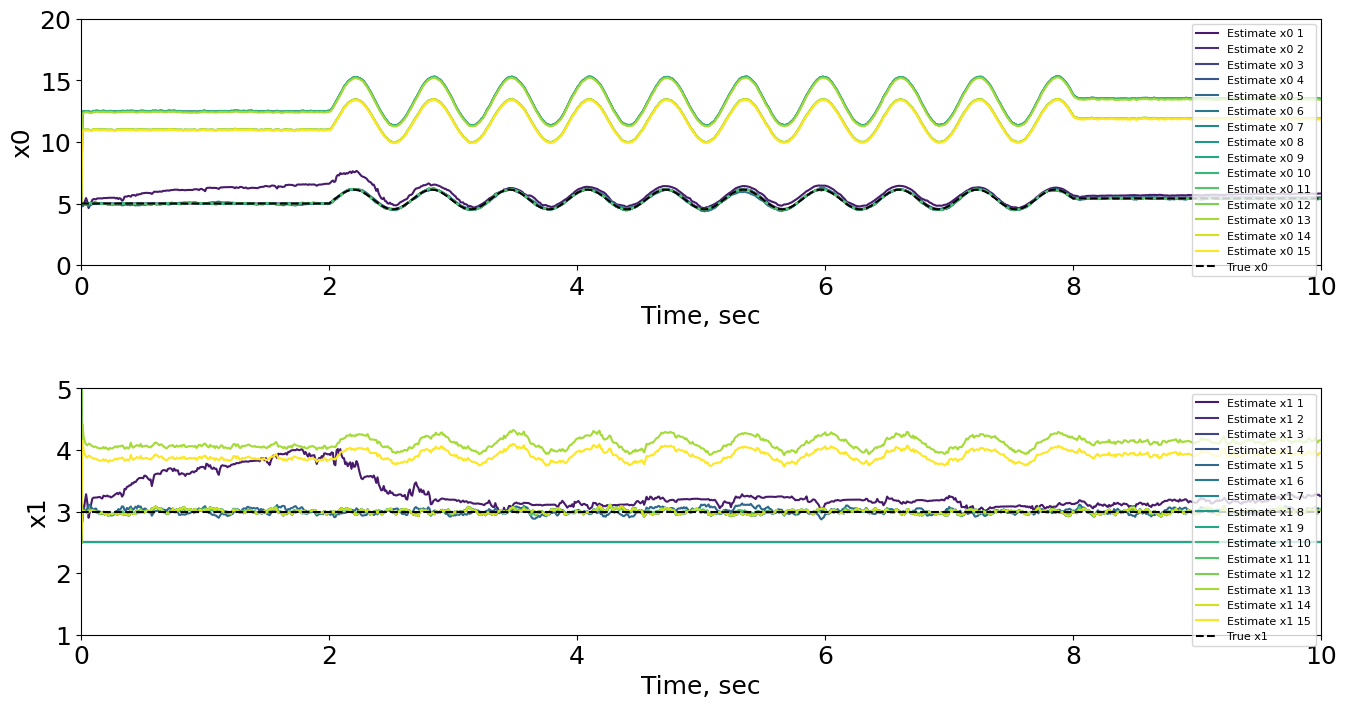

In [24]:
# plot the results using 2 subplots
fig, axs = plt.subplots(2, 1, figsize=(16, 8))
fig.subplots_adjust(hspace=0.5)
# plot all 31 estimates of x0

# define a color map for the lines
cmap = plt.get_cmap('viridis', len(R_modified)+1)

for i in range(len(R_modified)):
    axs[0].plot(tsim, results[i]['x0_hat'], label=f'Estimate x0 {i+1}', color=cmap(i+1))
axs[0].set_xlabel('Time, sec')
axs[0].set_ylabel('x0')
axs[0].set_ylim([0, 20])
axs[0].set_xlim([0, 10])
# Plot x0 on the first subplot as a dashed line onm top of all other lines
axs[0].plot(tsim, X[0, :], label='True x0', linestyle='--', color='black')

# legend
axs[0].legend(loc='upper right', fontsize=8)

# plot all 31 estimates of x1
for i in range(len(R_modified)):
    axs[1].plot(tsim, results[i]['x1_hat'], label=f'Estimate x1 {i+1}', color=cmap(i+1))
axs[1].set_xlabel('Time, sec')
axs[1].set_ylabel('x1')
axs[1].set_ylim([1, 5])
axs[1].set_xlim([0, 10])
# Plot x1 on the second subplot
axs[1].plot(tsim, X[1, :], label='True x1', linestyle='--', color='black')
# legend
axs[1].legend(loc='upper right', fontsize=8)

plt.show()


# Cramer Rao Bound

### numerical jacobian

Maybe could be more efficient using ``jax``?

In [50]:
def jacobian(f, x0, u0, epsilon=0.001):
    
    # Get A
    Aj = []
    for i in range(len(f(x0,u0))):
        
        def f_scalar(x,u,i):
            x_new = f(x, u)
            return np.ravel(x_new)[i]
        
        j = scipy.optimize.approx_fprime(x0, f_scalar, epsilon, u0, i)
        Aj.append(j)
        
    # Get B
    Bj = []
    for i in range(len(f(x0,u0))):
        
        def f_scalar(u,x,i):
            x_new = f(x, u)
            return np.ravel(x_new)[i]
        
        j = scipy.optimize.approx_fprime(u0, f_scalar, epsilon, x0, i)
        Bj.append(j)
    
    return np.matrix(np.vstack(Aj)), np.matrix(np.vstack(Bj))

### cramer rao bound

In [51]:
inv = np.linalg.inv
all_invJk_diags = []
for i in range(len(R_modified)):
    results[i]['invJk_diags'] = np.nan
    Jk = inv(P0)
    i_invJk_diags = []
    Ri = R_modified[i]
    for j in range(len(tsim)):
        this_xhat = np.array([results[i]['x0_hat'][j], results[i]['x1_hat'][j]])
        this_u = U[:,j]

        A, B = jacobian(f_d, np.ravel(this_xhat), np.ravel(this_u))
        C, D = jacobian(h_d, np.ravel(this_xhat), np.ravel(this_u))

        Jk = inv(Q) - inv(Q)@A@inv(Jk + A.T@inv(Q)@A)@A.T@inv(Q) + C.T@inv(Ri)@C
        
        lamb = 1e-5
        Jk = Jk + lamb*np.eye(np.shape(Jk)[0])
        invJk = inv(Jk)
        i_invJk_diags.append(np.diag(invJk))
    all_invJk_diags.append(i_invJk_diags)

In [52]:
three_sigma_x0 = []
three_sigma_x1 = []
for i in range(len(R_modified)):
    i_three_sigma_x0 = []
    i_three_sigma_x1 = []
    for j in range(len(tsim)):
        i_three_sigma_x0.append(3*np.sqrt(all_invJk_diags[i][j][0]))
        i_three_sigma_x1.append(3*np.sqrt(all_invJk_diags[i][j][1]))
    three_sigma_x0.append(i_three_sigma_x0)
    three_sigma_x1.append(i_three_sigma_x1)

### show CRB

Red dashed lines are 3-sigma bounds determined by the KF.
Gray shading is the 3-sigma CRB bound. 

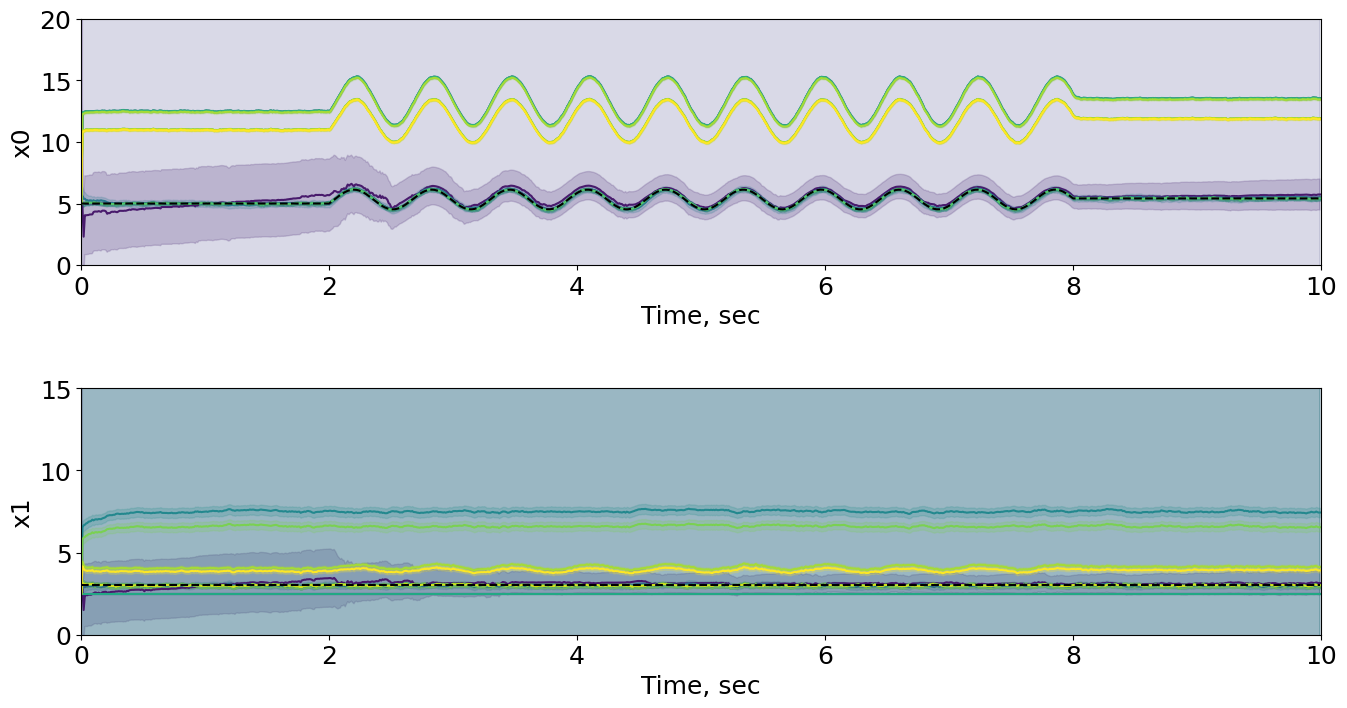

In [53]:
# plot all state estimates with 3 sigma bounds
fig, axs = plt.subplots(2, 1, figsize=(16, 8))
fig.subplots_adjust(hspace=0.5)
# plot all 31 estimates of x0
# define a color map for the lines
cmap = plt.get_cmap('viridis', len(R_modified)+1)
for i in range(len(R_modified)):
    axs[0].plot(tsim, results[i]['x0_hat'], label=f'Estimate x0 {i+1}', color=cmap(i+1))
    axs[0].fill_between(tsim, np.array(results[i]['x0_hat']) - np.array(three_sigma_x0[i]), 
                        np.array(results[i]['x0_hat']) + np.array(three_sigma_x0[i]), 
                        alpha=0.2, color=cmap(i+1))
axs[0].set_xlabel('Time, sec')
axs[0].set_ylabel('x0')
axs[0].set_ylim([0, 20])
axs[0].set_xlim([0, 10])
# Plot x0 on the first subplot as a dashed line onm top of all other lines
axs[0].plot(tsim, X[0, :], label='True x0', linestyle='--', color='black')
# legend
# axs[0].legend(loc='upper right', fontsize=8)
# plot all 31 estimates of x1
for i in range(len(R_modified)):
    axs[1].plot(tsim, results[i]['x1_hat'], label=f'Estimate x1 {i+1}', color=cmap(i+1))
    axs[1].fill_between(tsim, np.array(results[i]['x1_hat']) - np.array(three_sigma_x1[i]), 
                        np.array(results[i]['x1_hat']) + np.array(three_sigma_x1[i]), 
                        alpha=0.2, color=cmap(i+1))
axs[1].set_xlabel('Time, sec')
axs[1].set_ylabel('x1')
axs[1].set_ylim([0, 15])
axs[1].set_xlim([0, 10])
# Plot x1 on the second subplot
axs[1].plot(tsim, X[1, :], label='True x1', linestyle='--', color='black')
# legend
# axs[1].legend(loc='upper right', fontsize=8)
plt.show()

# Sorting out based on error

In [54]:
# for every position and velocity, if invJk is bigger than 1, then we want to disregard the data
# we will use invJk to determine if the data is trustworthy or not

trustworthy_x0 = []
trustworthy_x1 = []

for i in range(len(R_modified)):
    i_invJk_x0 = []
    i_invJk_x1 = []
    for j in range(len(tsim)):
        i_invJk_x0.append(all_invJk_diags[i][j][0])
        i_invJk_x1.append(all_invJk_diags[i][j][1])
    
    if np.mean(i_invJk_x0) < 100:
        trustworthy_x0.append(i)
    else:
        continue

    if np.mean(i_invJk_x1) < 100:
        trustworthy_x1.append(i)
    else:
        continue

print(trustworthy_x0)
print('valid combos x0: ', len(trustworthy_x0))
print(trustworthy_x1)
print('valid combos x1: ', len(trustworthy_x1))
    

[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
valid combos x0:  14
[0, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14]
valid combos x1:  11


## Re-plot only the trustworthy measurements

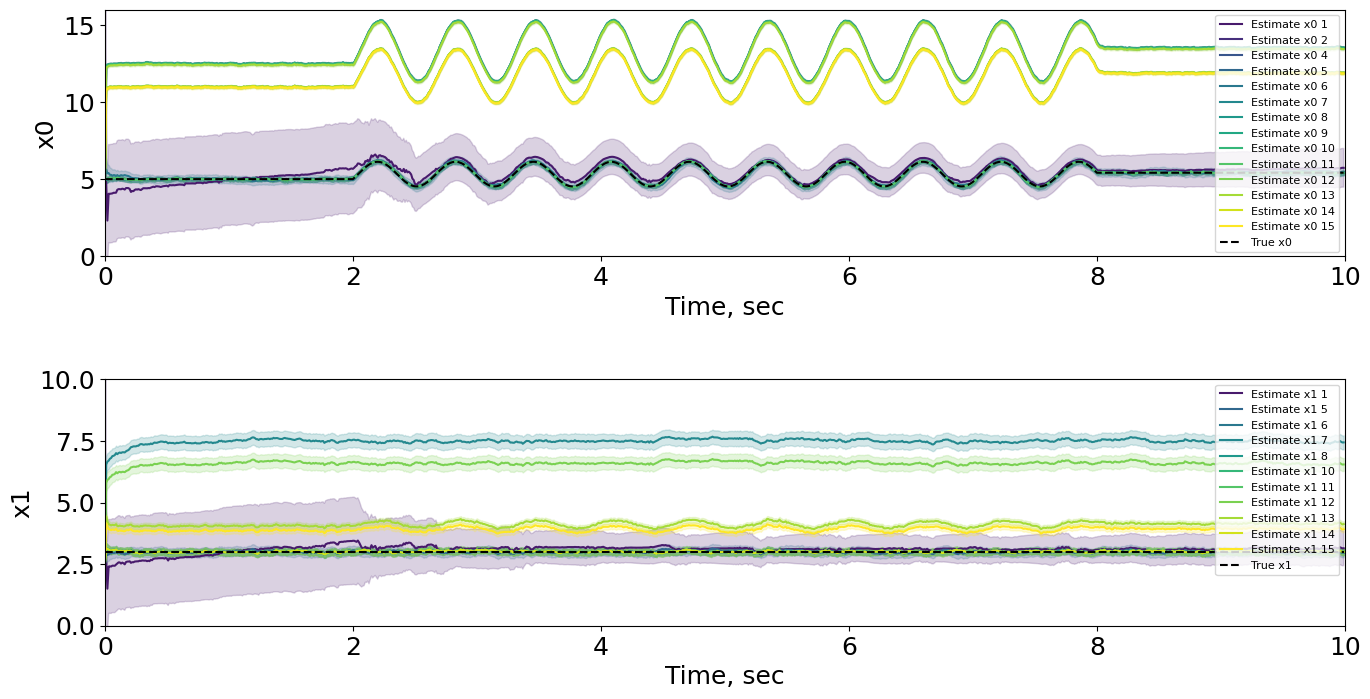

In [73]:
# Same plot as before, just only for the trustworthy data
fig, axs = plt.subplots(2, 1, figsize=(16, 8))
fig.subplots_adjust(hspace=0.5)
# define a color map for the lines
cmap = plt.get_cmap('viridis', len(R_modified)+1)
for i in range(len(R_modified)):
    if i in trustworthy_x0:
        axs[0].plot(tsim, results[i]['x0_hat'], label=f'Estimate x0 {i+1}', color=cmap(i+1))
        axs[0].fill_between(tsim, np.array(results[i]['x0_hat']) - np.array(three_sigma_x0[i]), 
                            np.array(results[i]['x0_hat']) + np.array(three_sigma_x0[i]), 
                            alpha=0.2, color=cmap(i+1))
axs[0].set_xlabel('Time, sec')
axs[0].set_ylabel('x0')
axs[0].set_ylim([0, 16])
axs[0].set_xlim([0, 10])
# Plot x0 on the first subplot as a dashed line onm top of all other lines
axs[0].plot(tsim, X[0, :], label='True x0', linestyle='--', color='black')
# legend
axs[0].legend(loc='upper right', fontsize=8)
for i in range(len(R_modified)):
    if i in trustworthy_x1:
        axs[1].plot(tsim, results[i]['x1_hat'], label=f'Estimate x1 {i+1}', color=cmap(i+1))
        axs[1].fill_between(tsim, np.array(results[i]['x1_hat']) - np.array(three_sigma_x1[i]), 
                            np.array(results[i]['x1_hat']) + np.array(three_sigma_x1[i]), 
                            alpha=0.2, color=cmap(i+1))
axs[1].set_xlabel('Time, sec')
axs[1].set_ylabel('x1')
axs[1].set_ylim([0, 10])
axs[1].set_xlim([0, 10])
# Plot x1 on the second subplot
axs[1].plot(tsim, X[1, :], label='True x1', linestyle='--', color='black')
# legend
axs[1].legend(loc='upper right', fontsize=8)
plt.show()

# Most Observable Section

In [63]:
# compute the average of the 3 sigma bounds for the trustowrthy data of both states

# find the average 3 sigma for the first 2 seconds of data
avg_trustworthy_x0 = []
avg_trustworthy_x1 = []
for i in range(len(trustworthy_x0)):
    avg_trustworthy_x0.append(np.mean(three_sigma_x0[trustworthy_x0[i]][500:600]))
for i in range(len(trustworthy_x1)):
    avg_trustworthy_x1.append(np.mean(three_sigma_x1[trustworthy_x1[i]][400:500]))
print(np.mean(avg_trustworthy_x0))
print(np.mean(avg_trustworthy_x1))

# sorting parameters
time = 10
threshold = 0.2
threshold_x1 = 0.22
window_size = 1
step = 0.01

samples_per_window = int(window_size/step)

regions_x0 = []
start = None

# make windows based on the window size from the time
windows = []
for i in range(int(time/window_size)):
    windows.append([i*window_size, (i+1)*window_size])

#print(windows)

# for every window, check if the average of the 3 sigma bounds is less than the threshold
trustworthy_windows_x0 = []
for i in range(len(windows)):
    window = [int(windows[i][0]*samples_per_window), int(windows[i][1]* samples_per_window)]
    window_avg = []
    for j in range(len(trustworthy_x0)):
        window_avg.append(np.mean(three_sigma_x0[trustworthy_x0[j]][window[0]:window[1]]))
    if np.mean(window_avg) < threshold:
        trustworthy_windows_x0.append(windows[i])
    else:
        continue
print(trustworthy_windows_x0)

# do the same for x1
trustworthy_windows_x1 = []
for i in range(len(windows)):
    window = [int(windows[i][0]*samples_per_window), int(windows[i][1]* samples_per_window)]
    window_avg = []
    for j in range(len(trustworthy_x1)):
        window_avg.append(np.mean(three_sigma_x1[trustworthy_x1[j]][window[0]:window[1]]))
    if np.mean(window_avg) < threshold_x1:
        trustworthy_windows_x1.append(windows[i])
    else:
        continue
print(trustworthy_windows_x1)

0.17674961339347156
0.2044728609823011
[[3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10]]
[[3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10]]


Now, plot only the data from the trustworthy windows.

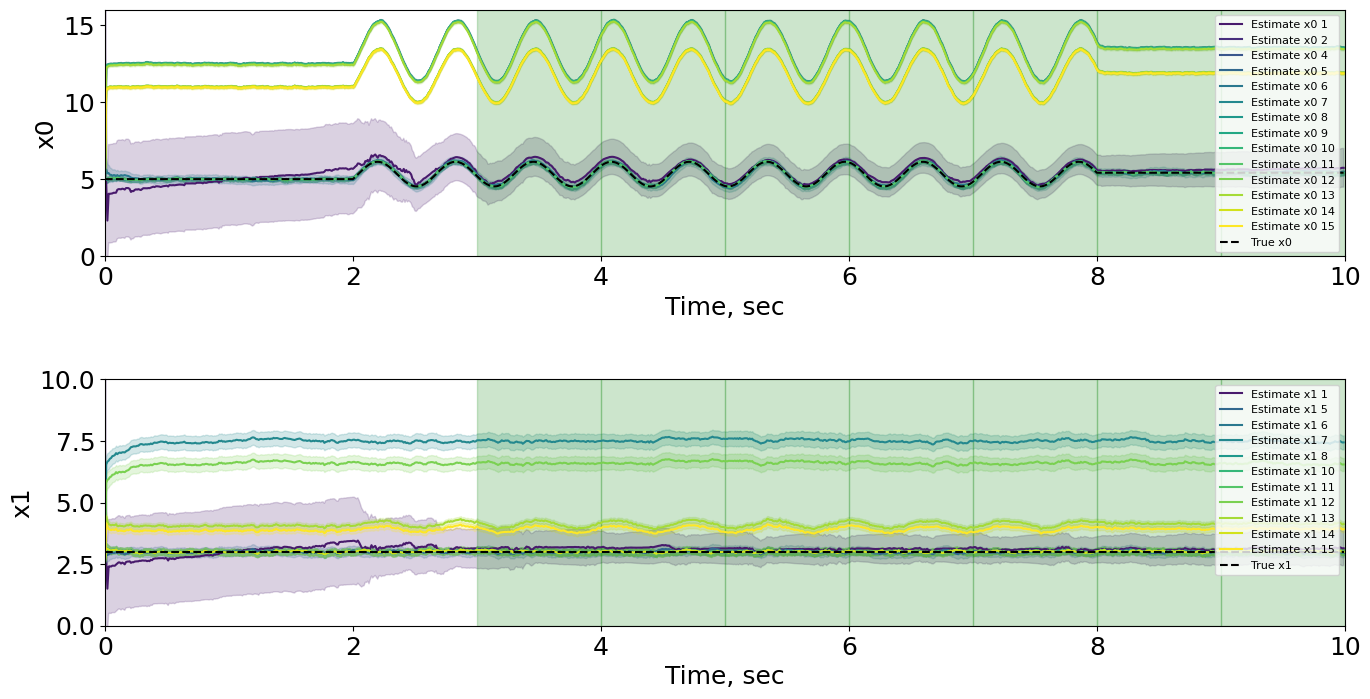

In [72]:
# plot only trustworthy windows
fig, axs = plt.subplots(2, 1, figsize=(16, 8))
fig.subplots_adjust(hspace=0.5)
# define a color map for the lines
cmap = plt.get_cmap('viridis', len(R_modified)+1)
for i in range(len(R_modified)):
    if i in trustworthy_x0:
        axs[0].plot(tsim, results[i]['x0_hat'], label=f'Estimate x0 {i+1}', color=cmap(i+1))
        axs[0].fill_between(tsim, np.array(results[i]['x0_hat']) - np.array(three_sigma_x0[i]), 
                            np.array(results[i]['x0_hat']) + np.array(three_sigma_x0[i]), 
                            alpha=0.2, color=cmap(i+1))
axs[0].set_xlabel('Time, sec')
axs[0].set_ylabel('x0')
axs[0].set_ylim([0, 16])
axs[0].set_xlim([0, 10])
# Plot x0 on the first subplot as a dashed line onm top of all other lines
axs[0].plot(tsim, X[0, :], label='True x0', linestyle='--', color='black')
# legend
axs[0].legend(loc='upper right', fontsize=8)
for i in range(len(R_modified)):
    if i in trustworthy_x1:
        axs[1].plot(tsim, results[i]['x1_hat'], label=f'Estimate x1 {i+1}', color=cmap(i+1))
        axs[1].fill_between(tsim, np.array(results[i]['x1_hat']) - np.array(three_sigma_x1[i]), 
                            np.array(results[i]['x1_hat']) + np.array(three_sigma_x1[i]), 
                            alpha=0.2, color=cmap(i+1))
axs[1].set_xlabel('Time, sec')
axs[1].set_ylabel('x1')
axs[1].set_ylim([0, 10])
axs[1].set_xlim([0, 10])
# Plot x1 on the second subplot
axs[1].plot(tsim, X[1, :], label='True x1', linestyle='--', color='black')
# legend
axs[1].legend(loc='upper right', fontsize=8)
# plot the trustworthy windows
for i in range(len(trustworthy_windows_x0)):
    axs[0].axvspan(trustworthy_windows_x0[i][0], trustworthy_windows_x0[i][1], color='green', alpha=0.2)
for i in range(len(trustworthy_windows_x1)):
    axs[1].axvspan(trustworthy_windows_x1[i][0], trustworthy_windows_x1[i][1], color='green', alpha=0.2)
plt.show()

# Agreement Heatmap
Now, put all the trustworthy measurements into a heatmap to how they agree. Here are the required functions:

In [65]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# function to make the adjacency matrix
def make_adjacency_matrix(trustworthy_data_indices, state, time_start, time_end, thresh):
    overlaps = np.ones((len(trustworthy_data_indices), len(trustworthy_data_indices)))
    for i in range(len(trustworthy_data_indices)):
        for j in range(len(trustworthy_data_indices)):
            if i == j:
                continue
            else:
                R_i = trustworthy_data_indices[i]
                R_j = trustworthy_data_indices[j]

                # get the data from both indices and only at the trustworthy time window
                # x_i = results[R_i][state]
                # x_j = results[R_j][state]
                x_i = results[R_i][state][time_start:time_end]
                x_j = results[R_j][state][time_start:time_end]

                # Set the acceptable error threshold
                threshold = thresh

                # Get the time that the data falls within the error range
                overlap = np.sum(np.logical_and(x_i - threshold < x_j, x_j < x_i + threshold)) / len(x_i)
                overlaps[i, j] = overlap
    # sort the adjacency matrix based on th]e sum of rows
    row_sums = overlaps.sum(axis=1)
    sorted_indices = np.argsort(row_sums)[::-1]
    
    sorted_overlaps = overlaps[sorted_indices][:, sorted_indices]

    return sorted_overlaps, sorted_indices

# function to plot the adjacency matrix
def plot_adjacency_matrix(matrix, indices, title):
    # Create a custom colormap
    colors =["red", "blue"]
    cmap = "custom colormap"
    custom_cmap = LinearSegmentedColormap.from_list(cmap, colors, N=100)

    # plot the adjacency matrix with the custom color map
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_title(title)
    ax.set_xlabel("How much does the data of this sensor combo...")
    ax.set_ylabel("Fall into the error range of this sensor combo?")
    sns.heatmap(matrix, cmap=custom_cmap, annot=True, fmt=".2f", cbar=False, square=True, linewidths=.5, annot_kws={"size": 5})
    ax.set_xticklabels(indices)
    ax.set_yticklabels(indices)
    # font size
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.show()


Making the adjacency matrices and plotting them.

300 1000
300 1000
[ 9  3  6  1  4 13 12 11 10  8  7  5  2  0]
14
(14, 14)

[ 2  6  9  5  4  1  0 10  8  7  3]
11
(11, 11)


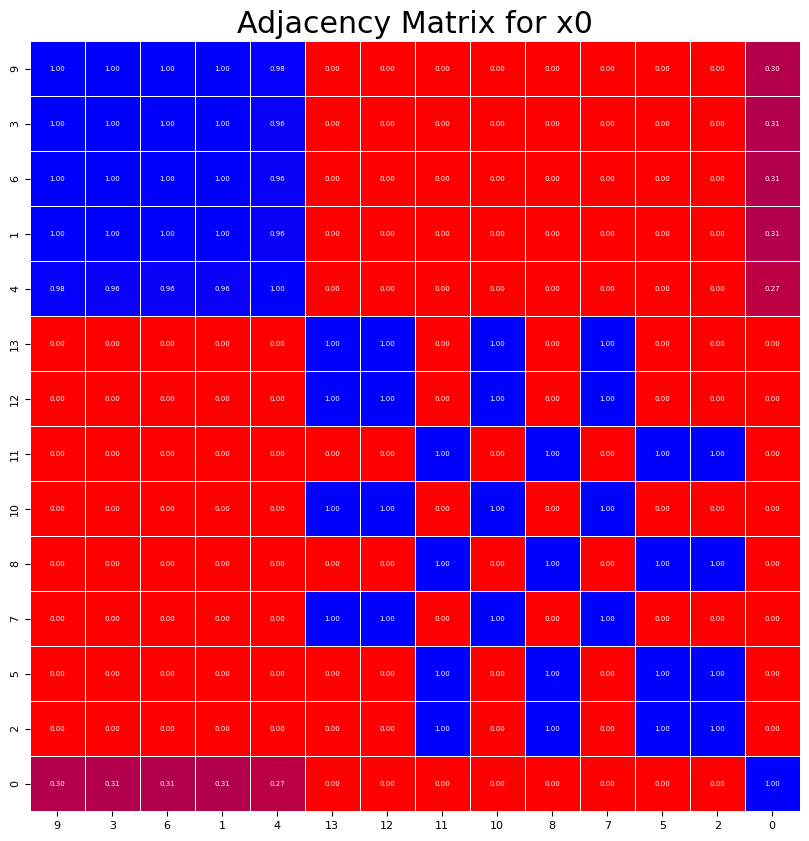

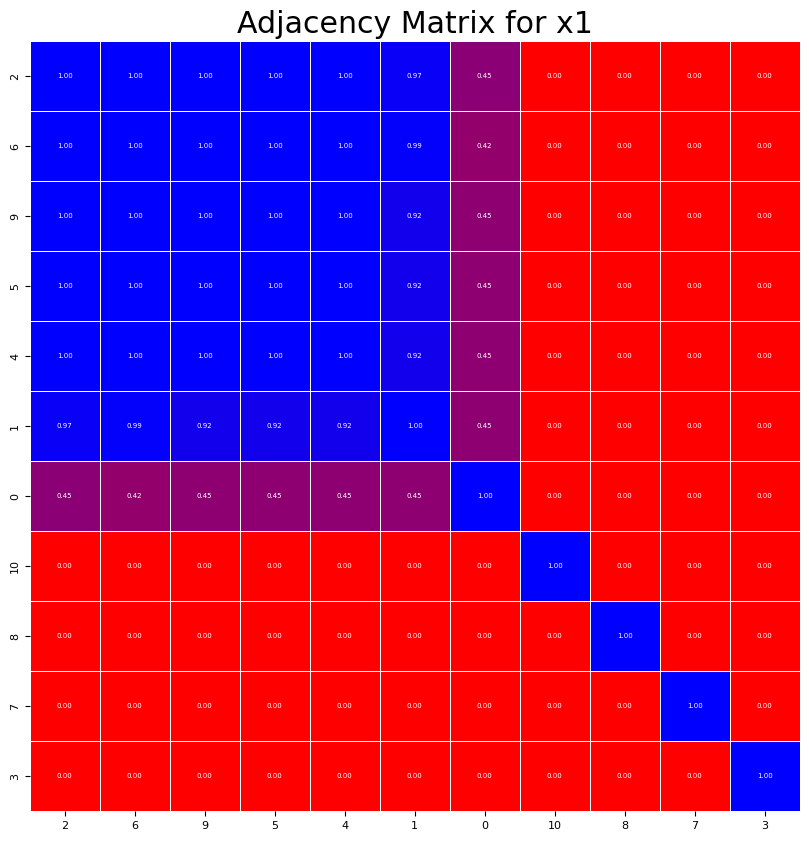

In [ ]:
x0_time = []
for i in range(len(trustworthy_windows_x0)):
    x0_time.append([int(trustworthy_windows_x0[i][0]*samples_per_window), int(trustworthy_windows_x0[i][1]* samples_per_window)])
x1_time = []
for i in range(len(trustworthy_windows_x1)):
    x1_time.append([int(trustworthy_windows_x1[i][0]*samples_per_window), int(trustworthy_windows_x1[i][1]* samples_per_window)])

x0_start = x0_time[0][0]
x0_end = x0_time[-1][1]

x1_start = x1_time[0][0]
x1_end = x1_time[-1][1]

x0_thresh = 0.15
x1_thresh = 0.1

adj_x0, indices_x0 = make_adjacency_matrix(trustworthy_x0, 'x0_hat', x0_start, x0_end, x0_thresh)
adj_x1, indices_x1 = make_adjacency_matrix(trustworthy_x1, 'x1_hat', x1_start, x1_end, x1_thresh)

print(indices_x0)
print(len(indices_x0))
print(adj_x0.shape)
print()
print(indices_x1)
print(len(indices_x1))
print(adj_x1.shape)

# for i in range(len(R_modified)):
#     print('combination ', i)
#     print(R_modified[i])

plot_adjacency_matrix(adj_x0, indices_x0, 'Adjacency Matrix for x0')
plot_adjacency_matrix(adj_x1, indices_x1, 'Adjacency Matrix for x1')

# Sensor Identification 
Now, find the largest cliques and the sensors that are not in them.

Note that this function currently does not work properly as of May 6th. I tried to change some things to be in a function to make it more convinient and it kind of broke it. Work in progress......

In [75]:
import networkx as nx
# write a function that can idebntify the clusters in the adjacency matrix
def clusters(matrix, indices, thresh):
    matrix = np.array(matrix)
    threshold = thresh

    # threshold matrix
    binary_matrix = (matrix > threshold).astype(int)

    # Graph
    G = nx.from_numpy_array(binary_matrix)

    # find cliques
    cliques = list(nx.find_cliques(G))

    for i in range(len(cliques)):
        this_clique = cliques[i]
        for j in range(len(this_clique)):
            this_clique[j] = indices[this_clique[j]]
    
    largest_clique = max(cliques, key=len)
    # print(largest_clique)

    return largest_clique

largest_clique_x0 = clusters(adj_x0, indices_x0, 0.8)
largest_clique_x1 = clusters(adj_x1, indices_x1, 0.8)

print(largest_clique_x0)
print(largest_clique_x1)

for i in range(len(largest_clique_x0)):
    print(R_modified[largest_clique_x0[i]])
    print()

[9, 3, 6, 1, 4]
[2, 6, 9, 5, 4, 1]
[[1.e+20 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+20 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e-02 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e-02]]

[[1.e+20 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+20 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+20 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e-02]]

[[1.e-02 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+20 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+20 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e-02]]

[[1.e+20 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e-02 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+20 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+20]]

[[1.e-02 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e-02 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+20 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+20]]



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


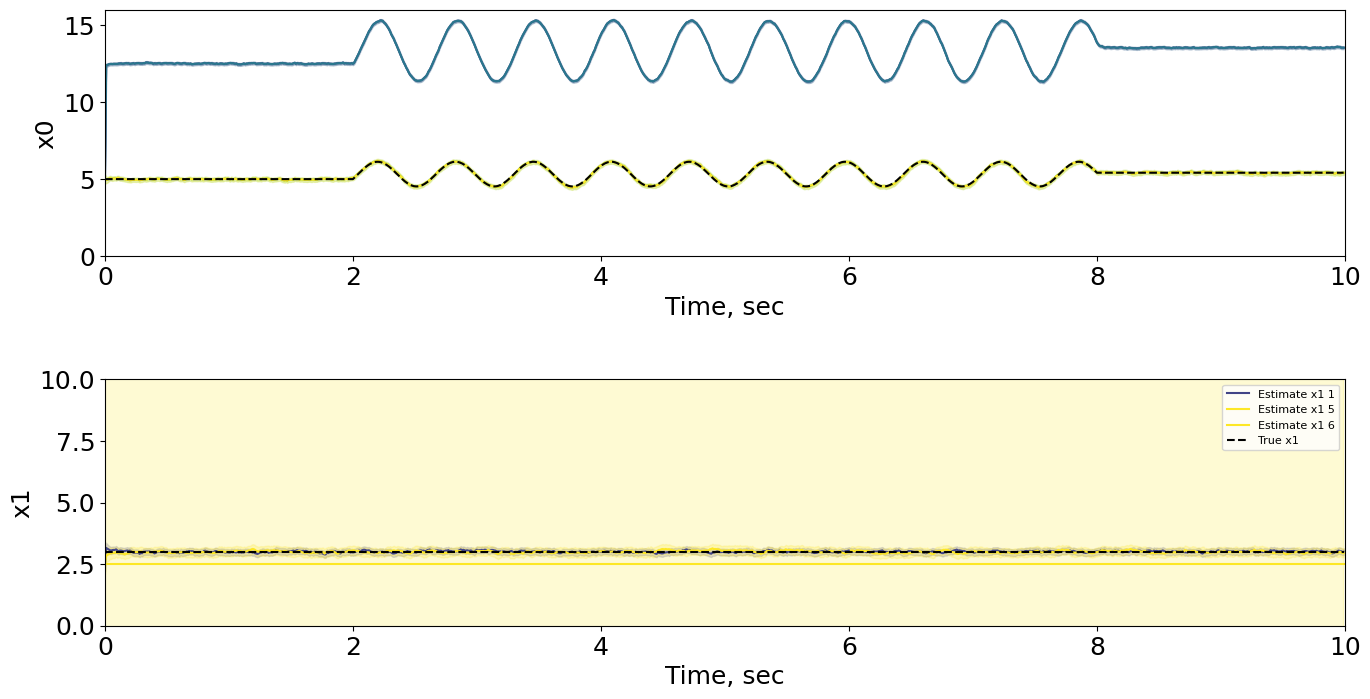

In [80]:
# plot only trustworthy windows
fig, axs = plt.subplots(2, 1, figsize=(16, 8))
fig.subplots_adjust(hspace=0.5)
# define a color map for the lines
cmap = plt.get_cmap('viridis', len(largest_clique_x0)+1)
for i in range(len(largest_clique_x0)):
    if i in trustworthy_x0:
        axs[0].plot(tsim, results[largest_clique_x0[i]]['x0_hat'], label=f'Estimate x0 {i+1}', color=cmap(i+1))
        axs[0].fill_between(tsim, np.array(results[largest_clique_x0[i]]['x0_hat']) - np.array(three_sigma_x0[largest_clique_x0[i]]), 
                            np.array(results[largest_clique_x0[i]]['x0_hat']) + np.array(three_sigma_x0[largest_clique_x0[i]]), 
                            alpha=0.2, color=cmap(i+1))
axs[0].set_xlabel('Time, sec')
axs[0].set_ylabel('x0')
axs[0].set_ylim([0, 16])
axs[0].set_xlim([0, 10])
# Plot x0 on the first subplot as a dashed line onm top of all other lines
axs[0].plot(tsim, X[0, :], label='True x0', linestyle='--', color='black')
# legend
axs[1].legend(loc='upper right', fontsize=8)
for i in range(len(largest_clique_x1)):
    if i in trustworthy_x1:
        axs[1].plot(tsim, results[largest_clique_x1[i]]['x1_hat'], label=f'Estimate x1 {i+1}', color=cmap(i+1))
        axs[1].fill_between(tsim, np.array(results[largest_clique_x1[i]]['x1_hat']) - np.array(three_sigma_x1[largest_clique_x1[i]]), 
                            np.array(results[largest_clique_x1[i]]['x1_hat']) + np.array(three_sigma_x1[largest_clique_x1[i]]), 
                            alpha=0.2, color=cmap(i+1))
axs[1].set_xlabel('Time, sec')
axs[1].set_ylabel('x1')
axs[1].set_ylim([0, 10])
axs[1].set_xlim([0, 10])
# Plot x1 on the second subplot
axs[1].plot(tsim, X[1, :], label='True x1', linestyle='--', color='black')
# legend
axs[1].legend(loc='upper right', fontsize=8)

plt.show()